In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import missingno as msno

In [2]:
df=pd.read_csv("C:/Users/LENOVO/Documents/GD/TP3/dataset.csv")
#df=pd.read_csv("C:/Users/LENOVO/Documents/GD/TP1/tp1.csv")

In [3]:
#Lecture des 5 prem lignes du dataFrame
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
#Obtenir le type des donnees de chaque colonne du dataFrame
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
#calcul des donnees manquantes pour chaque attribut
missing_values_count = df.isnull().sum()
missing_values_count

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

<Axes: >

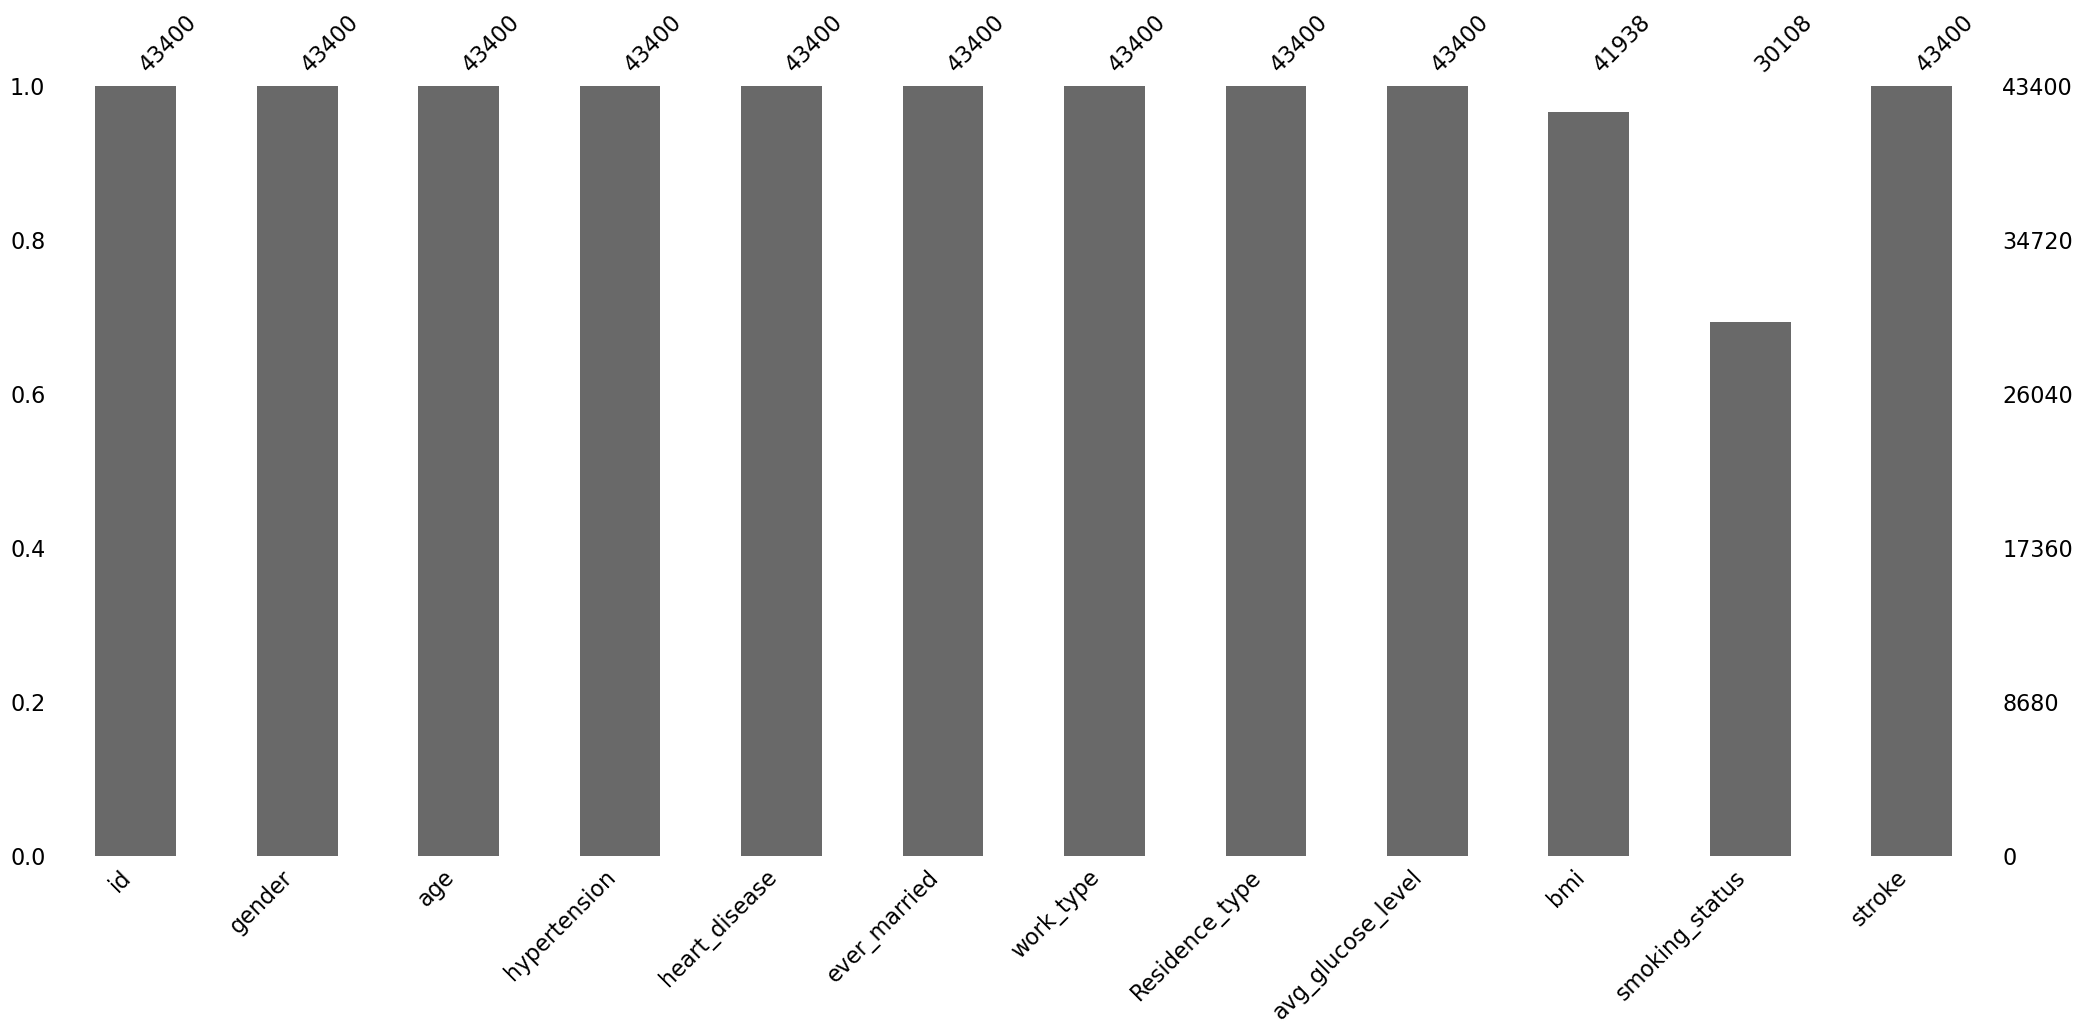

In [6]:
#rep graphique des donnees manquantes 
msno.bar(df)

In [7]:
# Liste des colonnes catégorielles (y compris 'object' et les colonnes avec 0 ou 1)

#l'attribut columns est utilisé pour obtenir la liste des noms des colonnes selec par select_dtypes
#.tolist() :convertir la liste des noms de colonnes en une liste Python standard.
colonnes_categorielles = df.select_dtypes(include=['object']).columns.tolist()
# isin([0, 1]) :vérifie si tous les éléments de la colonne sont soit 0, soit 1.
# Ajouter les colonnes contenant 0 ou 1
colonnes_01 = [colonne for colonne in df.columns if df[colonne].isin([0, 1]).all()]
colonnes_categorielles.extend(colonnes_01)

In [8]:
colonnes_numeriques = df.select_dtypes(include=['float']).columns

In [9]:
#créer des nouveaux DataFrame l une contennant les colonnes num et l autre categ
df_categoriel = df[colonnes_categorielles]
df_numerique = df[colonnes_numeriques]

In [10]:
# Afficher les noms des colonnes catégorielles
print("Colonnes catégorielles:")
print(list(colonnes_categorielles))

# Afficher les noms des colonnes numériques
print("\nColonnes numériques:")
print(list(colonnes_numeriques))


Colonnes catégorielles:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']

Colonnes numériques:
['age', 'avg_glucose_level', 'bmi']


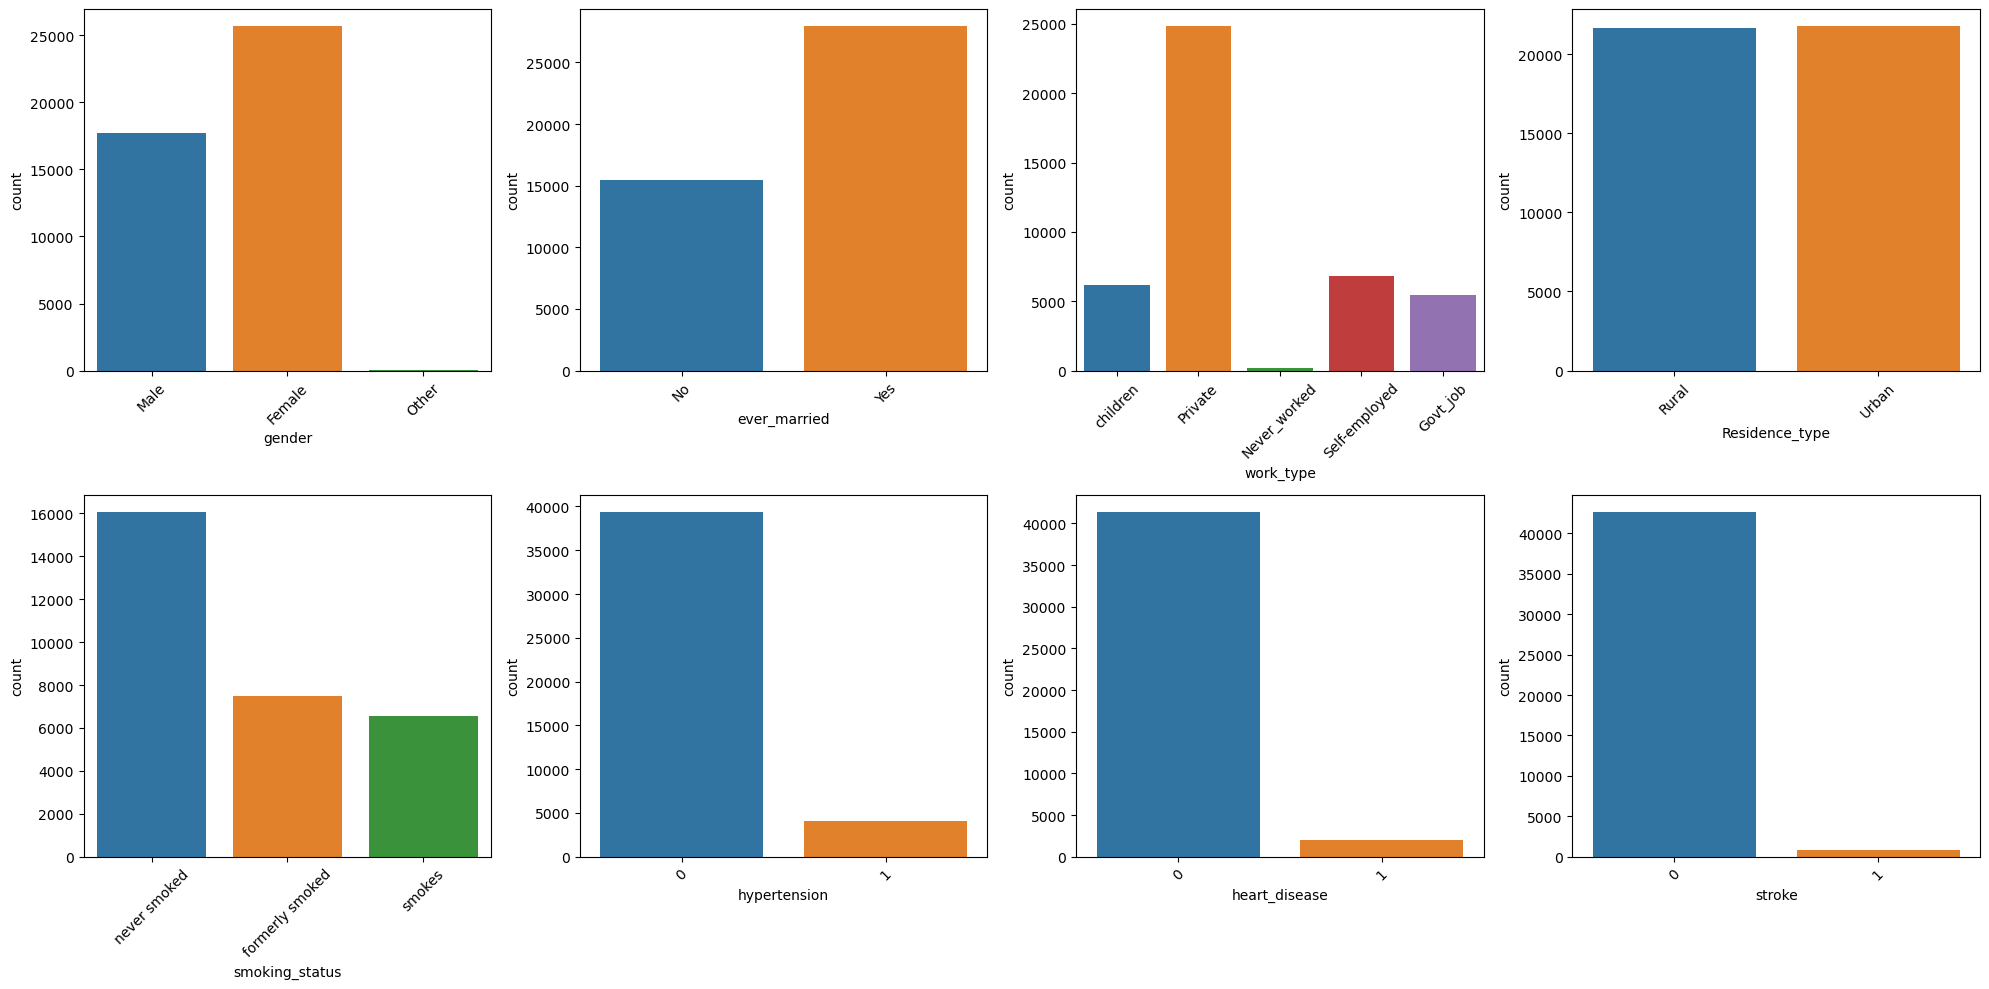

In [11]:
import seaborn as sb
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for var, subplot in zip(colonnes_categorielles, axs.flatten()):
    #print(var,subplot)
    sb.countplot(x=var, data=df, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


Entrez le nom de la variable cible : stroke


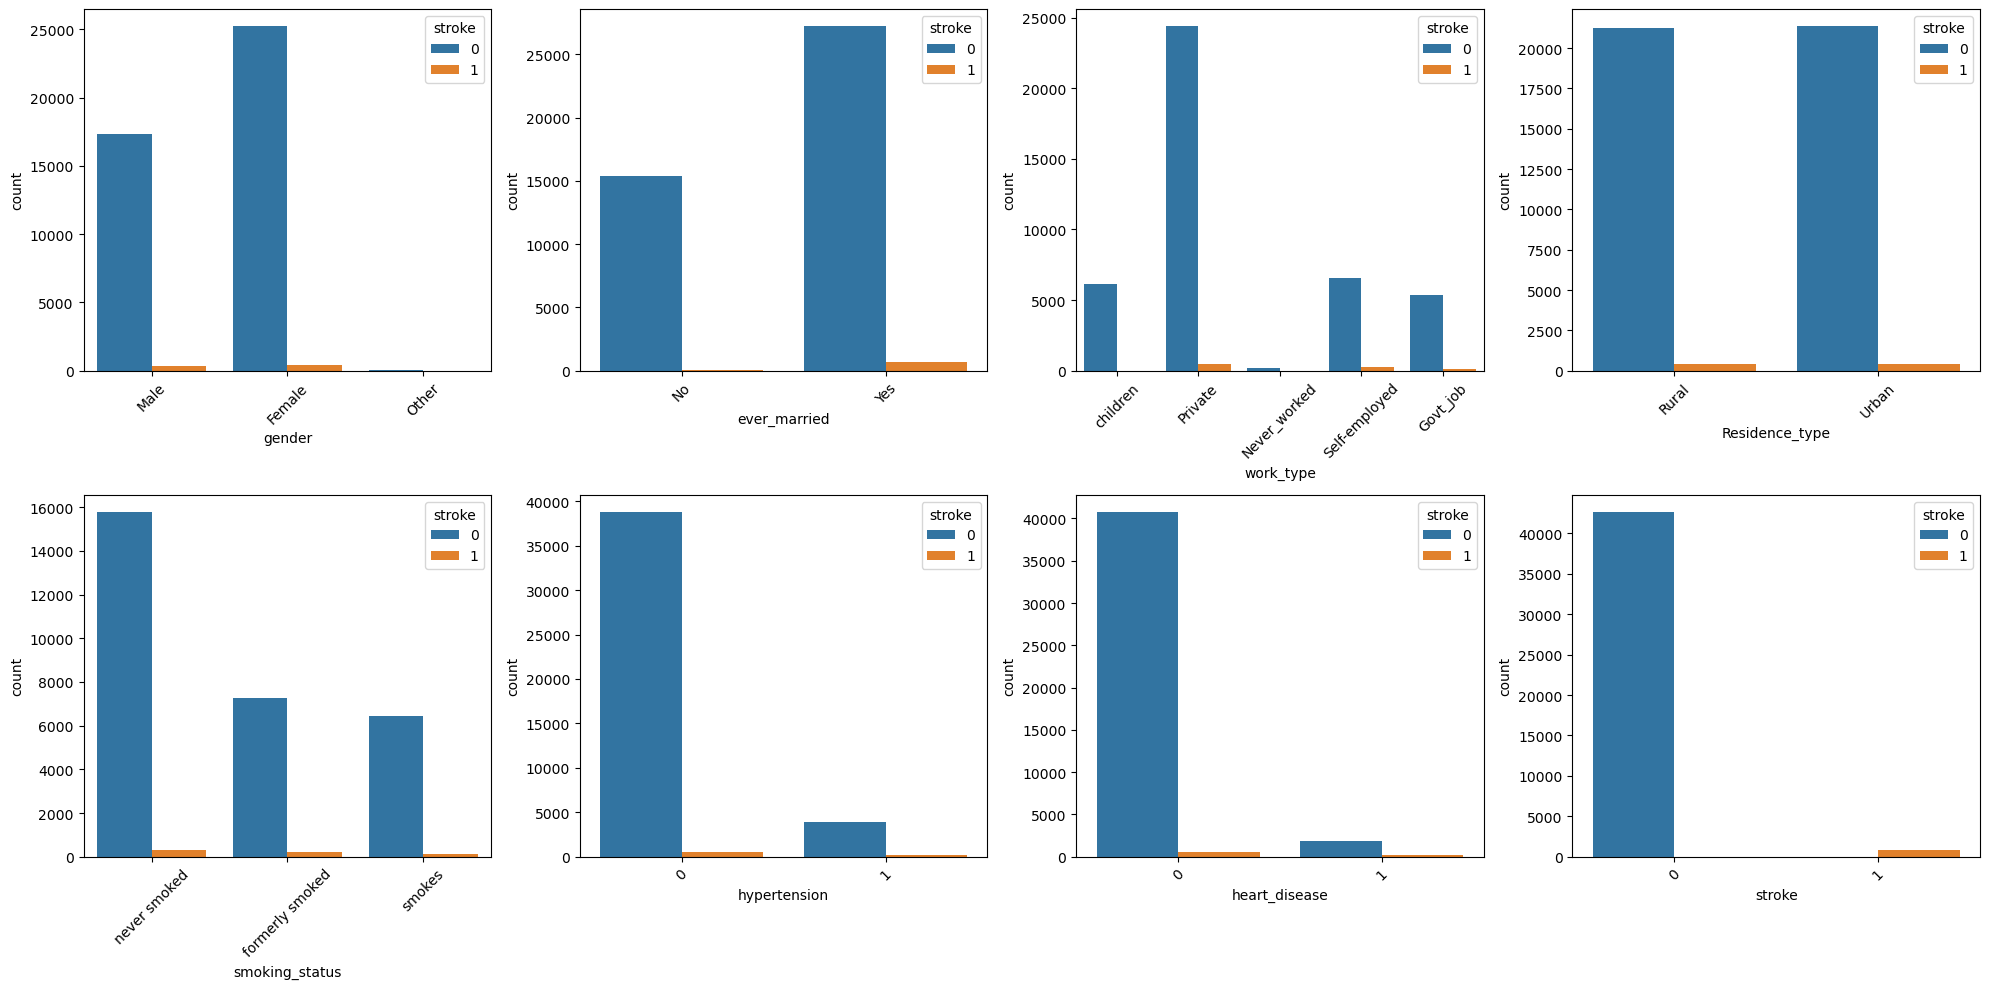

In [12]:

# Demander à l'utilisateur de choisir la variable cible
target_variable = input("Entrez le nom de la variable cible : ")

if target_variable not in df.columns:
    print("La variable cible n'est pas valide.")
else:
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for var, subplot in zip(colonnes_categorielles, axs.flatten()):
        sb.countplot(x=df[var], hue=df[target_variable], ax=subplot)
        for label in subplot.get_xticklabels():
            label.set_rotation(45)

    plt.tight_layout()
    plt.show()


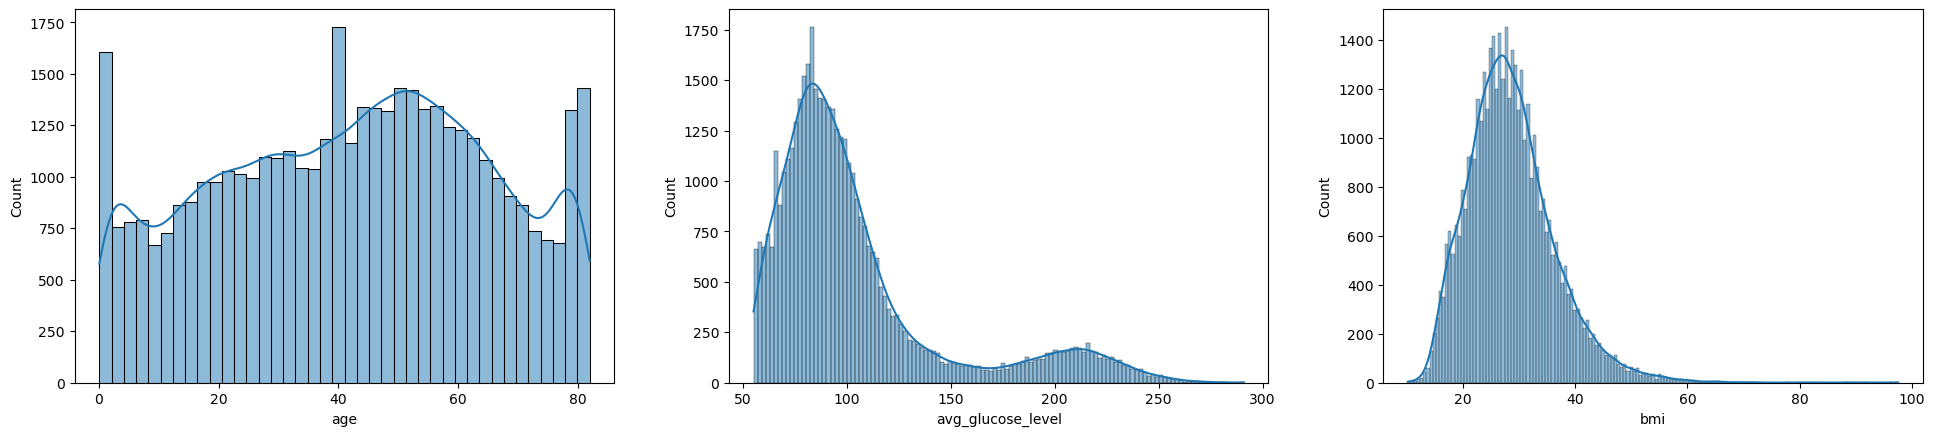

In [13]:
# variabe numerique

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for var, subplot in zip(colonnes_numeriques, axs.flatten()):
    sb.histplot(df[var], kde=True, ax=subplot)

plt.tight_layout(pad=3)
plt.show()

Entrez le nom de la variable cible : stroke


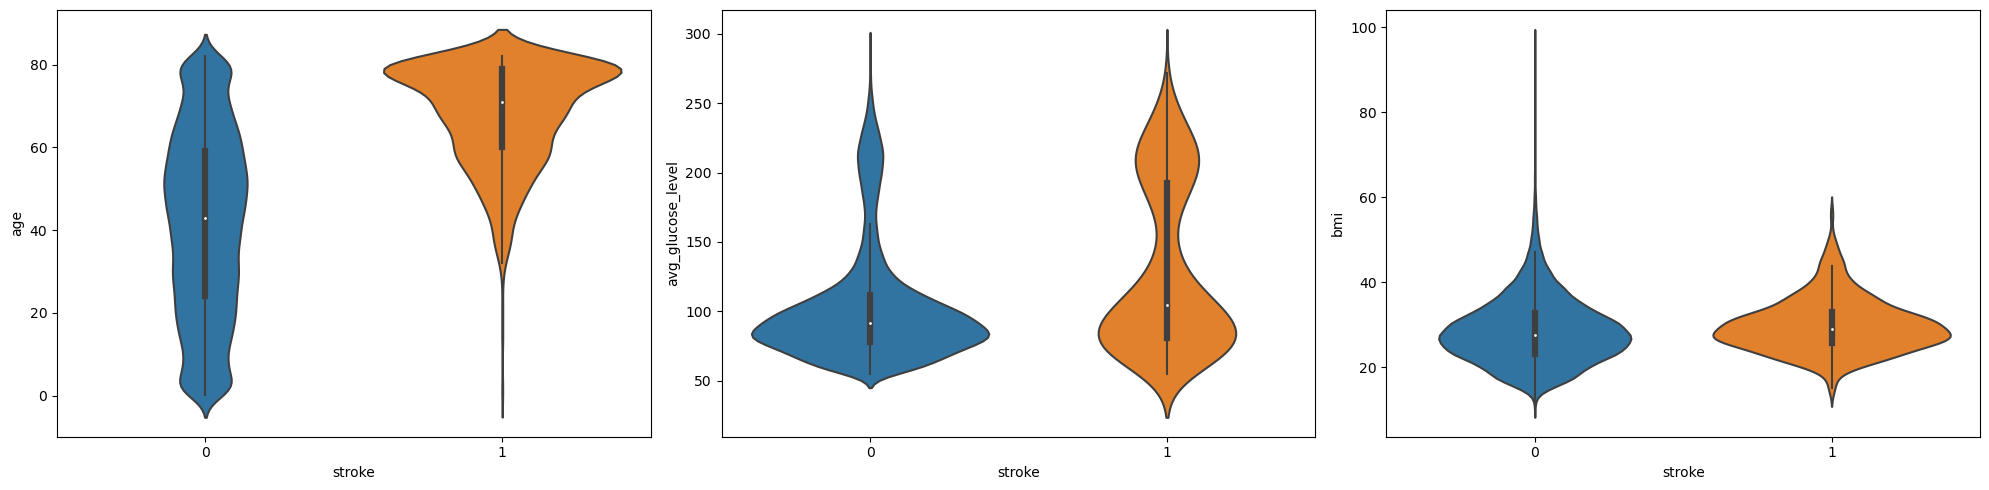

In [14]:
# Demander à l'utilisateur de choisir la variable cible
target_variable = input("Entrez le nom de la variable cible : ")

if target_variable not in df.columns:
    print("La variable cible n'est pas valide.")
else:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    for var, subplot in zip(colonnes_numeriques, axs.flatten()):
        sb.violinplot(x=df[target_variable], y=df[var], ax=subplot)

    plt.tight_layout()
    plt.show()


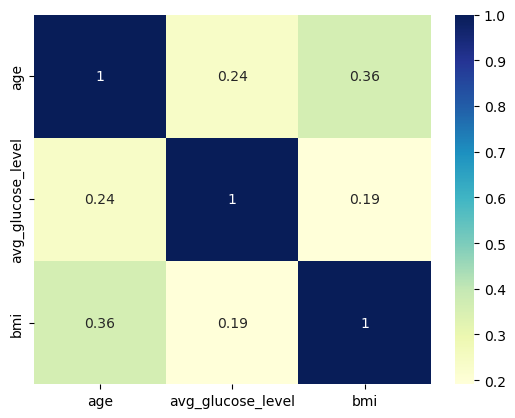

In [15]:
sb.heatmap(df_numerique.corr(), cmap="YlGnBu", annot = True)
plt.show()

Saisissez la borne inférieure de l'intervalle : 0
Saisissez la borne supérieure de l'intervalle : 120


<Axes: >

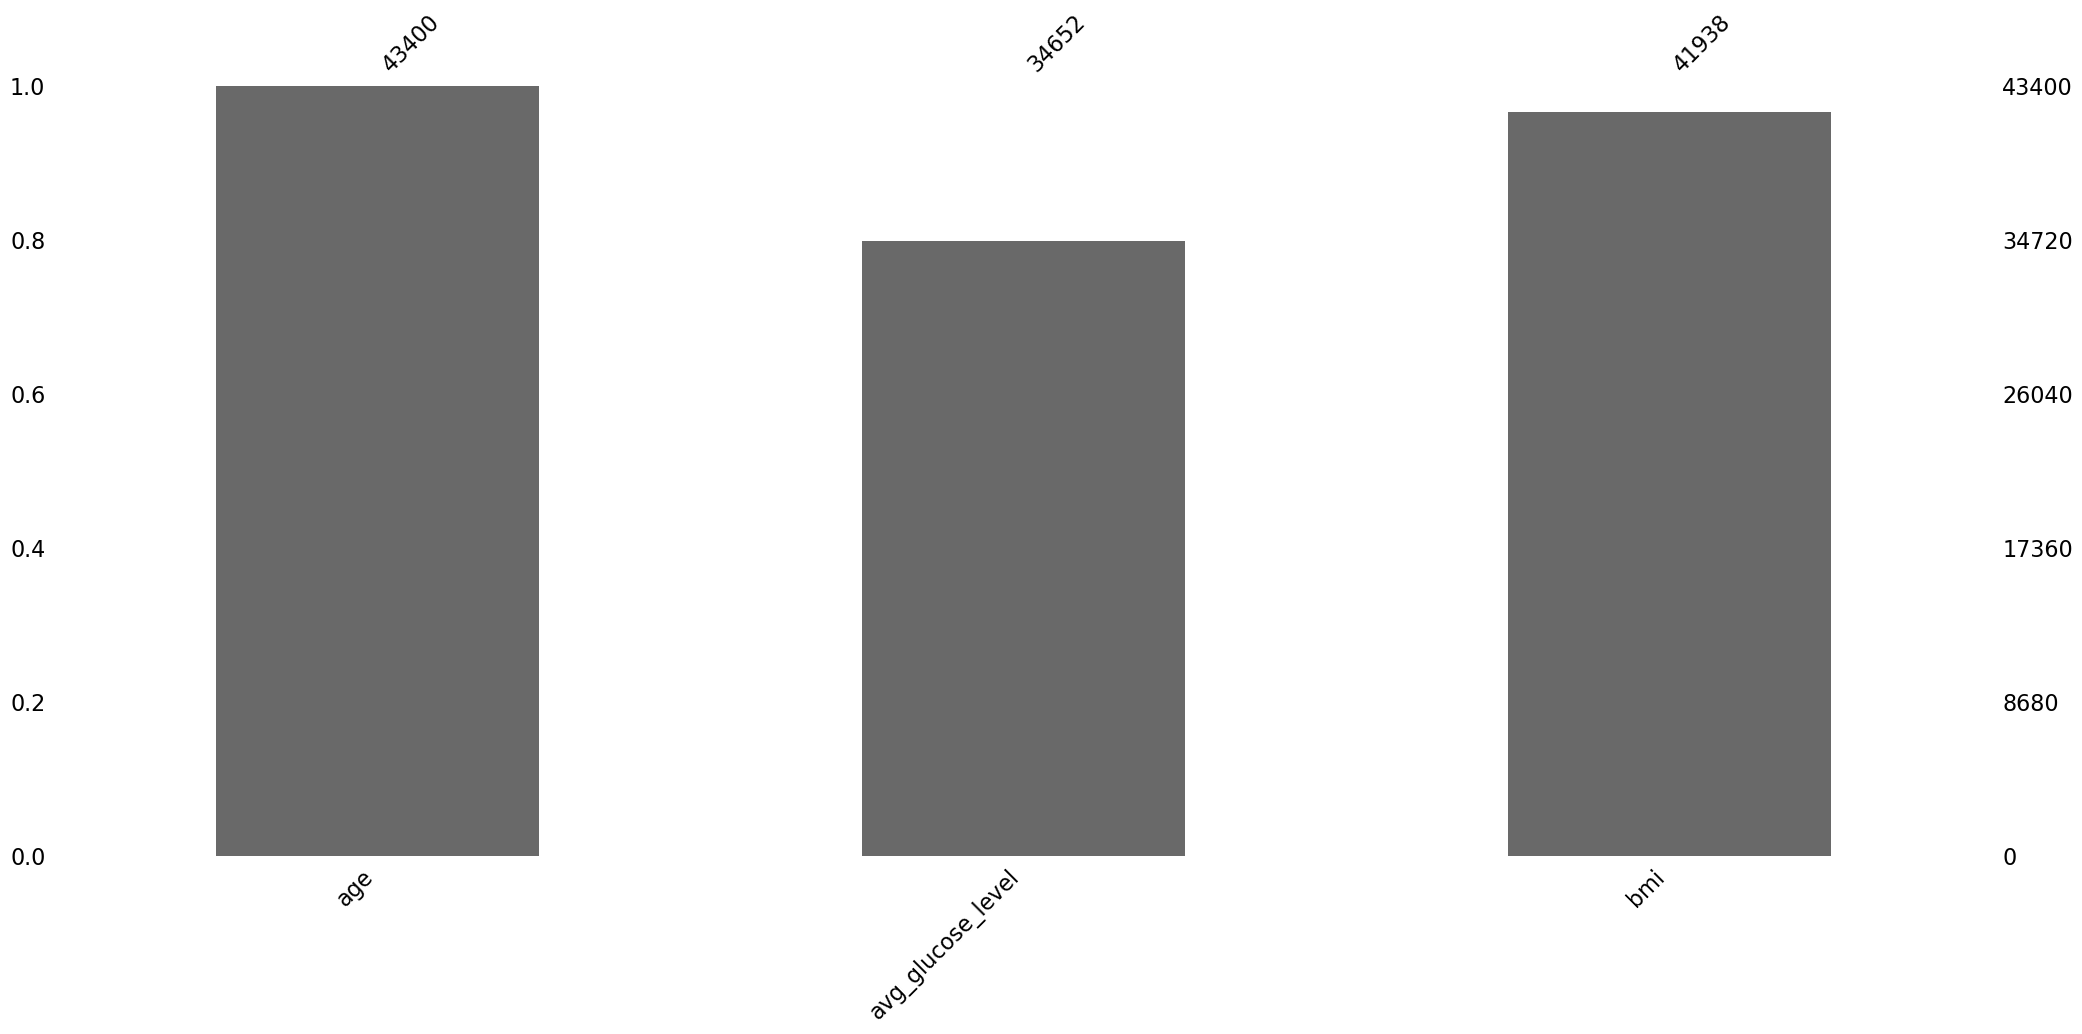

In [16]:
#On fait ceci pour supp les val num eronnees en resp l intervalle que l utilisateur va entrer
# Demander à l'utilisateur de saisir l'intervalle des valeurs numériques autorisées
borne_inf = float(input("Saisissez la borne inférieure de l'intervalle : "))
borne_sup = float(input("Saisissez la borne supérieure de l'intervalle : "))

# Filtrer les lignes en dehors de l'intervalle spécifié
df_numerique = df_numerique[(df_numerique[colonnes_numeriques] >= borne_inf) & (df_numerique[colonnes_numeriques] <= borne_sup)]

# Affichage des graphiques manquants après le filtrage
msno.bar(df_numerique)

Saisissez la valeur catégorielle à exclure pour la colonne gender : Others
Saisissez la valeur catégorielle à exclure pour la colonne ever_married : Rien
Saisissez la valeur catégorielle à exclure pour la colonne work_type : Rien
Saisissez la valeur catégorielle à exclure pour la colonne Residence_type : Rien
Saisissez la valeur catégorielle à exclure pour la colonne smoking_status : Rien
Saisissez la valeur catégorielle à exclure pour la colonne hypertension : Rien
Saisissez la valeur catégorielle à exclure pour la colonne heart_disease : Rien
Saisissez la valeur catégorielle à exclure pour la colonne stroke : Rien


<Axes: >

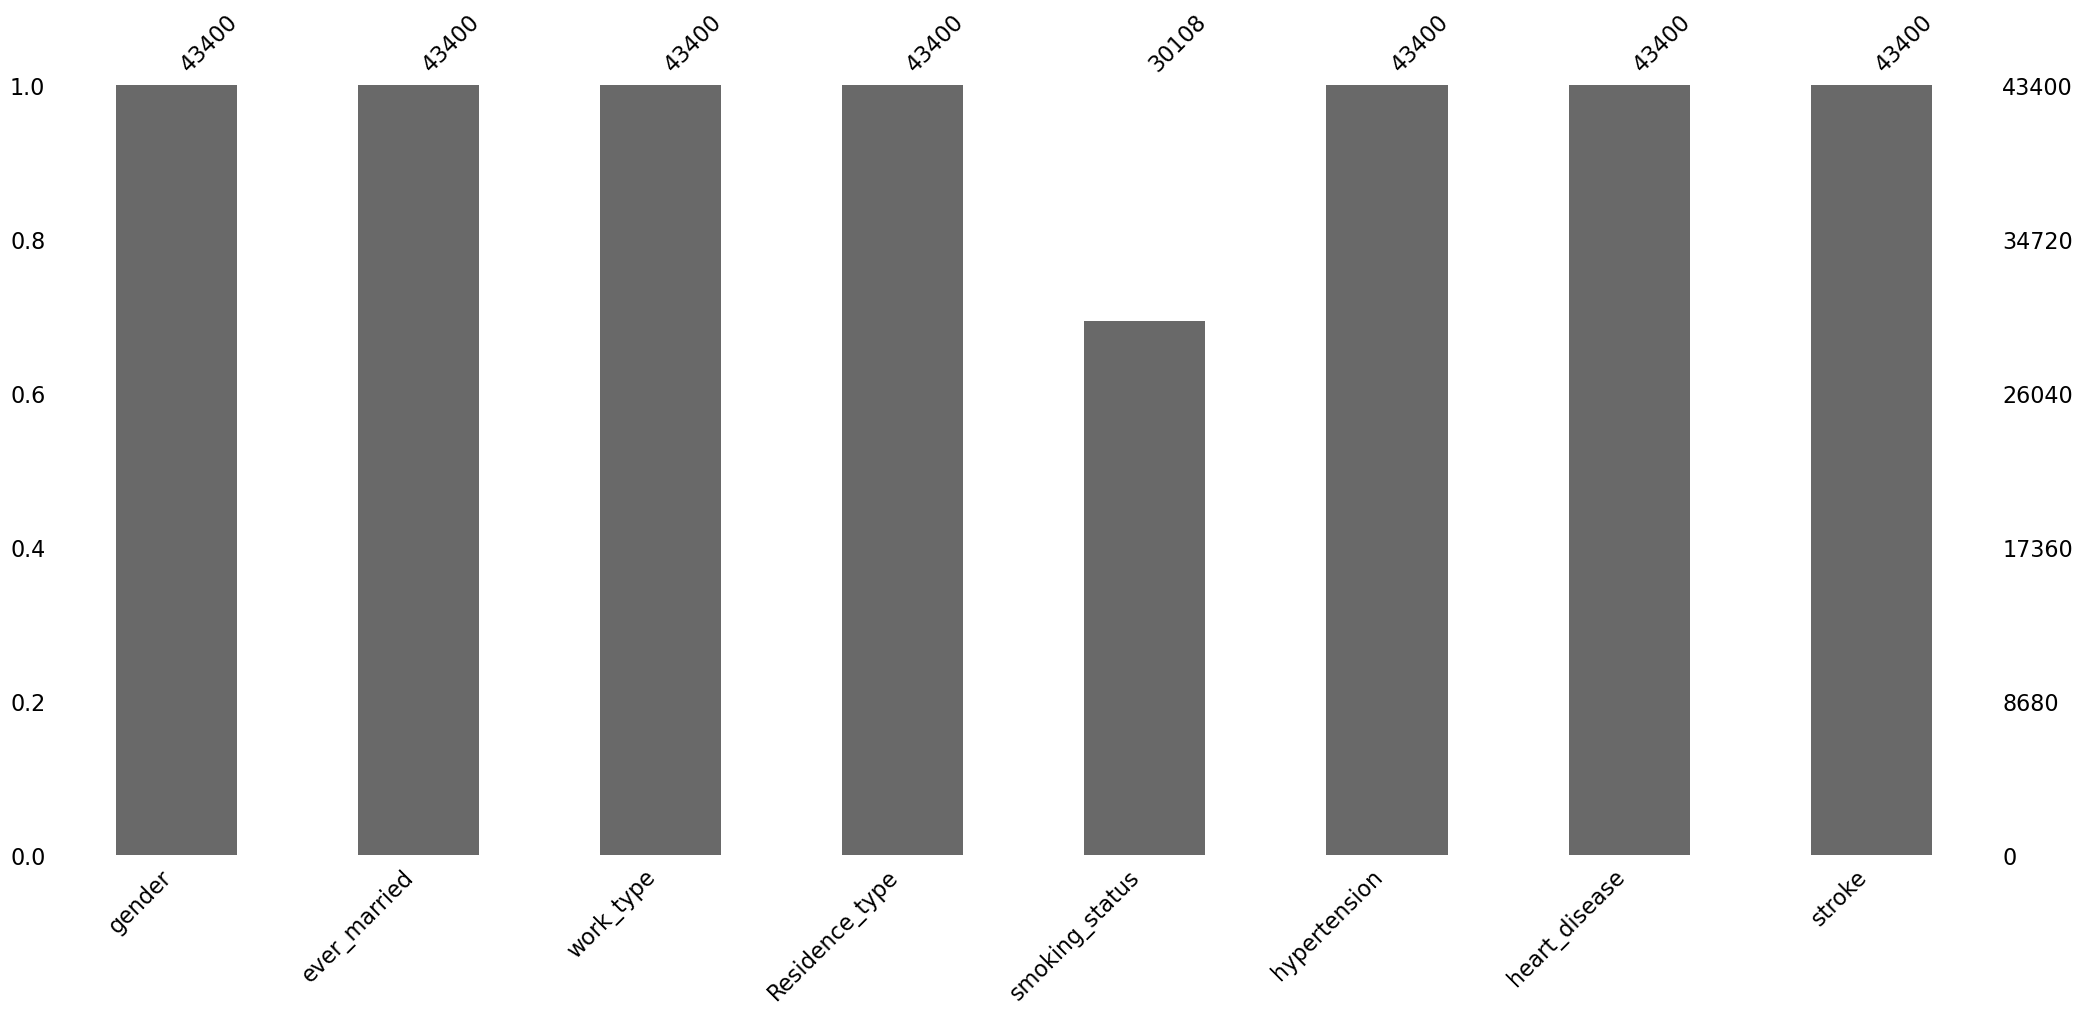

In [17]:
#On fait ceci pour supp les val categ eronnees 
#L'utilisateur va saisir la val qui ne veut pas avoir dans chaque colonne du df
# Filtrer les lignes contenant la valeur spécifiée dans les colonnes catégorielles
for colonne in colonnes_categorielles:
    valeur_a_exclure = input(f"Saisissez la valeur catégorielle à exclure pour la colonne {colonne} : ")
    df_categoriel = df_categoriel[df_categoriel[colonne] != valeur_a_exclure]

# Affichage des graphiques manquants après le filtrage
msno.bar(df_categoriel)


In [18]:
#Trouver les colonnes qui ne contiennent pas des val manquantes
#df_numerique.isna().sum()  hady bash tandiru la somme d ga3 les val manq l kul colonne num
non_na_columns = df_numerique.loc[: ,df_numerique.isna().sum() == 0].columns
non_na_columns

Index(['age'], dtype='object')

In [19]:
#Trouver les colonnes qui ne contiennent pas des val manquantes
non_na_columns1 = df_categoriel.loc[: ,df_categoriel.isna().sum() == 0].columns
non_na_columns1

Index(['gender', 'ever_married', 'work_type', 'Residence_type', 'hypertension',
       'heart_disease', 'stroke'],
      dtype='object')

In [20]:
# sélectionner les lignes où au moins une valeur est manquante (isna().any(axis=1)) dans un DataFrame numérique 
#(df_numerique) et les colonnes qui ne contiennent pas de valeurs manquantes (non_na_columns).
X_testeM = df_numerique.loc[df_numerique.isna().any(axis=1), non_na_columns]

In [21]:
X_testeM

,age
4,14.0
5,47.0
7,75.0
9,74.0
12,37.0
...,...
43388,64.0
43390,69.0
43392,18.0
43393,39.0


In [22]:
# sélectionner les lignes où au moins une valeur est manquante (isna().any(axis=1)) 
#dans un DataFrame catgorielle (df_categoriel) et les colonnes qui ne contiennent pas de valeurs manquantes (non_na_columns).
X_testeM1 = df_categoriel.loc[df_categoriel.isna().any(axis=1), non_na_columns1]


In [23]:
X_testeM1

,gender,ever_married,work_type,Residence_type,hypertension,heart_disease,stroke
0,Male,No,children,Rural,0,0,0
2,Female,No,Private,Urban,0,0,0
4,Male,No,Never_worked,Rural,0,0,0
5,Female,Yes,Private,Urban,0,0,0
10,Female,Yes,Govt_job,Urban,0,0,0
...,...,...,...,...,...,...,...
43382,Female,No,children,Urban,0,0,0
43385,Female,Yes,Self-employed,Urban,0,0,0
43389,Male,No,children,Urban,0,0,0
43391,Male,No,children,Urban,0,0,0


In [24]:
# Identifier les colonnes avec des valeurs manquantes des attributs num
colonnes_manquantes = df_numerique.columns[df_numerique.isna().any()].tolist()
colonnes_manquantes

['avg_glucose_level', 'bmi']

In [25]:
# Identifiez les colonnes avec des valeurs manquantes des attributs categ
colonnes_manquantes1 = df_categoriel.columns[df_categoriel.isna().any()].tolist()
colonnes_manquantes1

['smoking_status']

In [26]:
X = df_numerique.drop(colonnes_manquantes, axis=1)
y = df_numerique[colonnes_manquantes]


In [27]:
X1 = df_categoriel.drop(colonnes_manquantes1, axis=1)
y1 = df_categoriel[colonnes_manquantes1]


<Axes: >

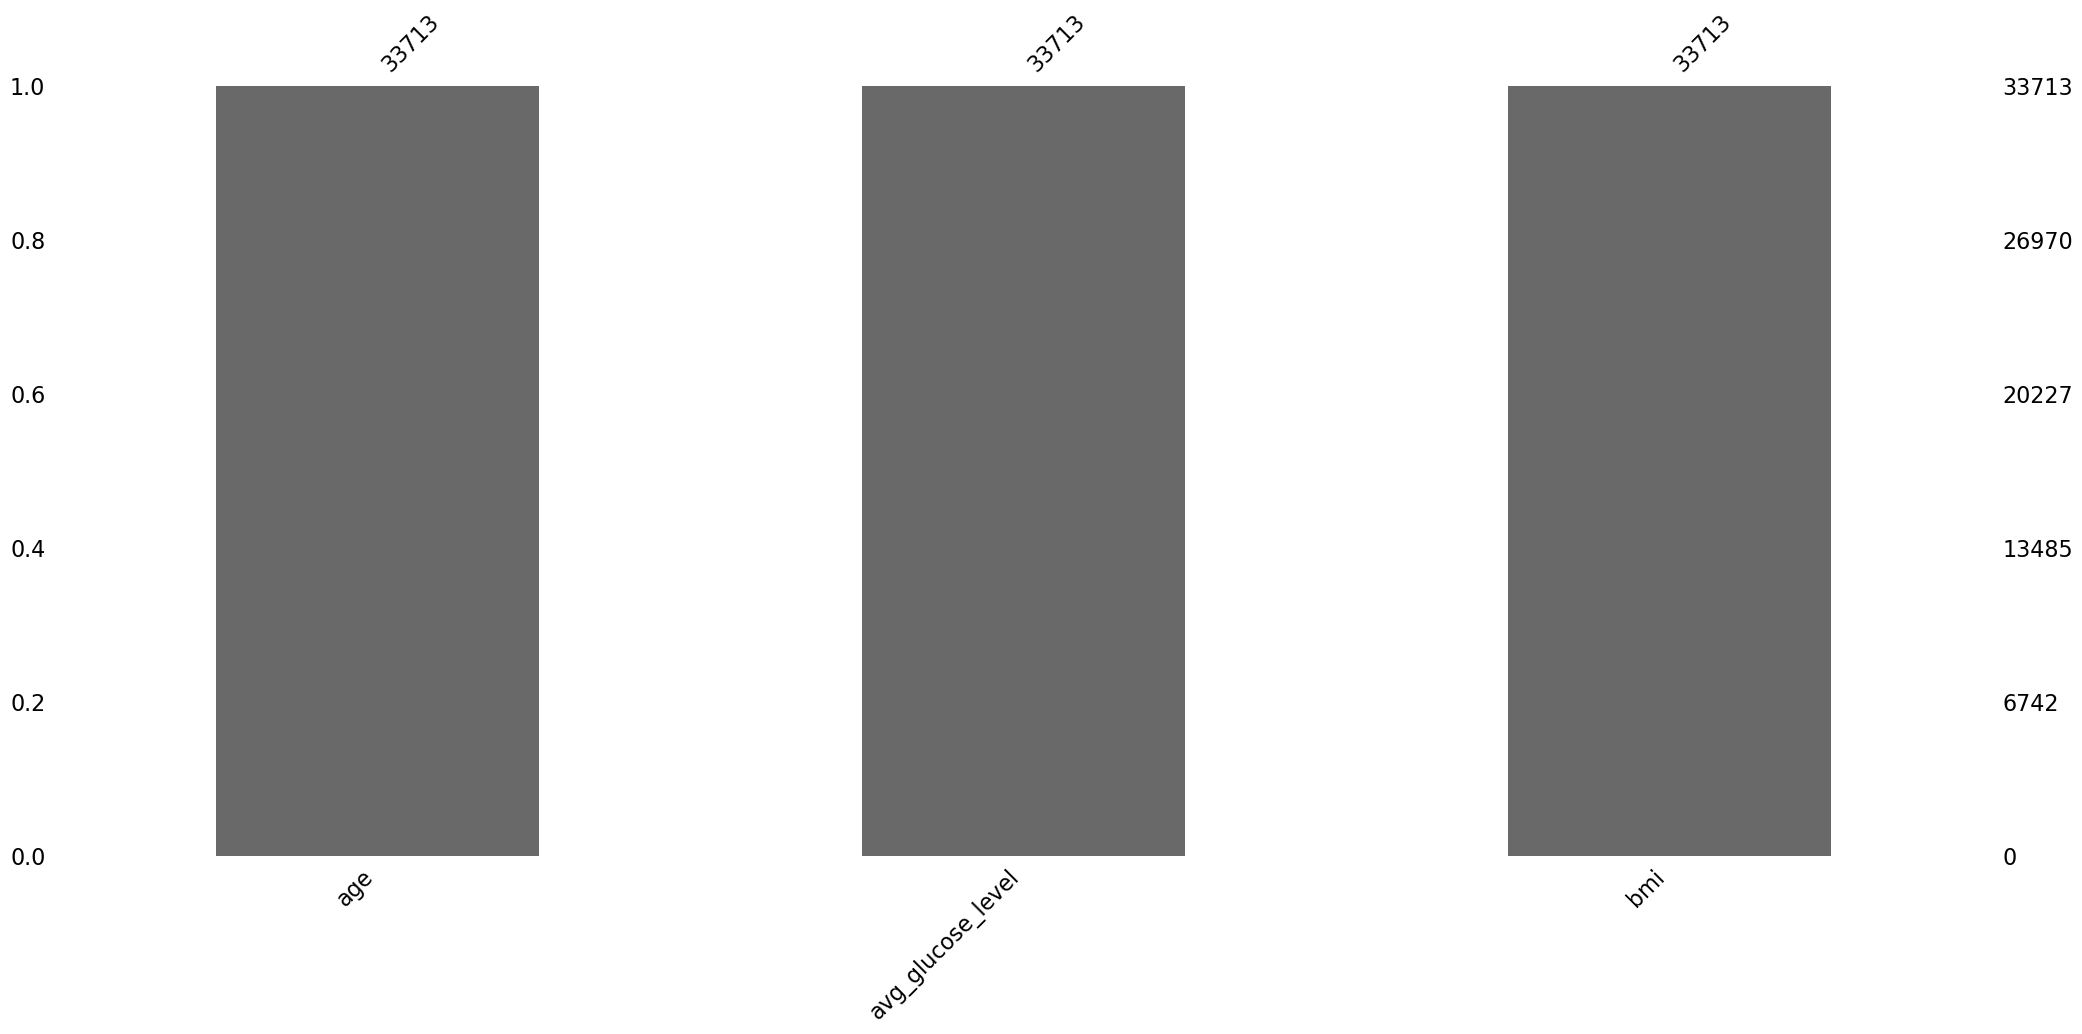

In [28]:
#supp toutes les lignes du DataFrame contennant en moins une val manq (num)
df_numerique=df_numerique.dropna()
msno.bar(df_numerique)

<Axes: >

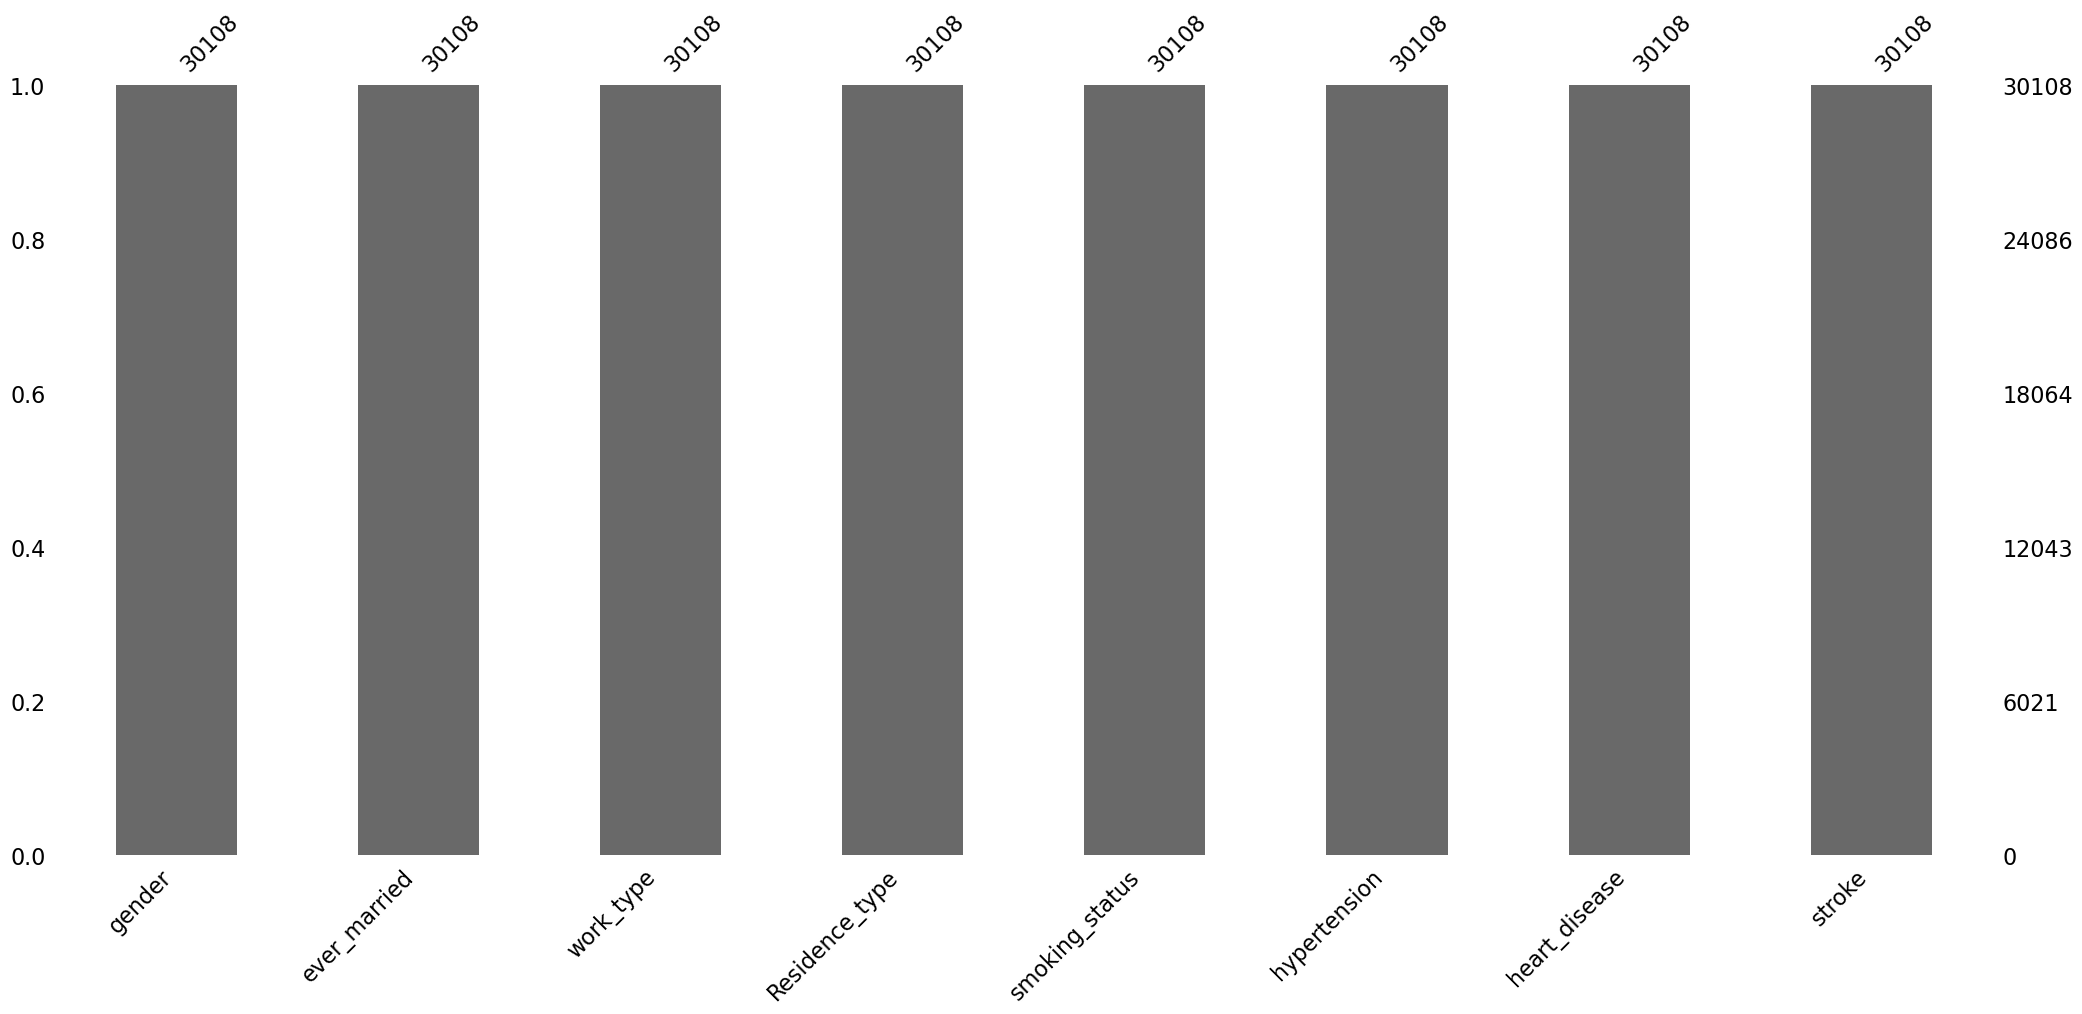

In [29]:
#supp toutes les lignes du DataFrame contennant en moins une val manq (categ)
df_categoriel=df_categoriel.dropna()
msno.bar(df_categoriel)


In [30]:
# Division des données en ensembles d'entraînement et de test
#Cette ligne calcule l'indice à partir duquel les données seront divisées en ensembles d'entraînement et de test. 
#un seuil (nombre d'observations) qui représente 80% des données, car 0.8 est multiplié par la longueur totale des données (len(X)).
splitlimit = int(len(df_numerique) * 0.8)
# affiche la valeur calculée de l'indice de séparation.
print(splitlimit)
#De même, cette ligne effectue la division des variables dépendantes en ensembles d'entraînement (y_train) et de test (y_test).
X_train, X_test = df_numerique.iloc[:splitlimit, :-1], df_numerique.iloc[splitlimit:, :-1]
y_train, y_test = df_numerique.iloc[:splitlimit, -1], df_numerique.iloc[splitlimit:, -1]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

26970
(26970, 2)
(6743, 2)
(26970,)
(6743,)


In [31]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to categorical columns in the DataFrame
for column in colonnes_categorielles:
    df_categoriel[column] = label_encoder.fit_transform(df_categoriel[column])

# Division des données en ensembles d'entraînement et de test
splitlimit1 = int(len(df_categoriel) * 0.8)
X_train1, X_test1 = df_categoriel.iloc[:splitlimit1, :-1], df_categoriel.iloc[splitlimit1:, :-1]
y_train1, y_test1 = df_categoriel.iloc[:splitlimit1, -1], df_categoriel.iloc[splitlimit1:, -1]
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)



(24086, 7)
(6022, 7)
(24086,)
(6022,)


In [76]:
from sklearn.metrics import r2_score

# Initialiser et entraîner le modèle KNeighborsRegressor
knnr = KNeighborsRegressor()
knnr.fit(X_train, y_train)
# Prédiction sur l'ensemble de test
y_pred = knnr.predict(X_test)
# Calcul du score du modèle
r2_knnr = r2_score(y_test, y_pred)
print(f"R² Score for KNeighborsRegressor: {r2_knnr}")

# Création et entraînement du modèle
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred1 = rf_reg.predict(X_test)
# Calcul du score R²
r2_reg = r2_score(y_test, y_pred1)
print(f"R² Score for RandomForestRegressor: {r2_reg}")

linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred2 = linreg.predict(X_test)

# Calcul du score du modèle
r2_linreg = r2_score(y_test, y_pred2)
print(f"R² Score for LinearRegression: {r2_linreg}") 

# Comparaison des scores et utilisation du modèle avec le score le plus élevé
if r2_knnr > r2_reg and r2_knnr > r2_linreg:
    selected_model = knnr
    print("KNeighborsRegressor selected.")
elif r2_reg > r2_knnr and r2_reg > r2_linreg:
    selected_model = rf_reg
    print("RandomForestRegressor selected.")
else:
    selected_model = linreg
    print("LinearRegression selected.")



R² Score for KNeighborsRegressor: 0.13654228341510477
R² Score for RandomForestRegressor: 0.06400170439234687
R² Score for LinearRegression: 0.13717602560896058
LinearRegression selected.


<Axes: >

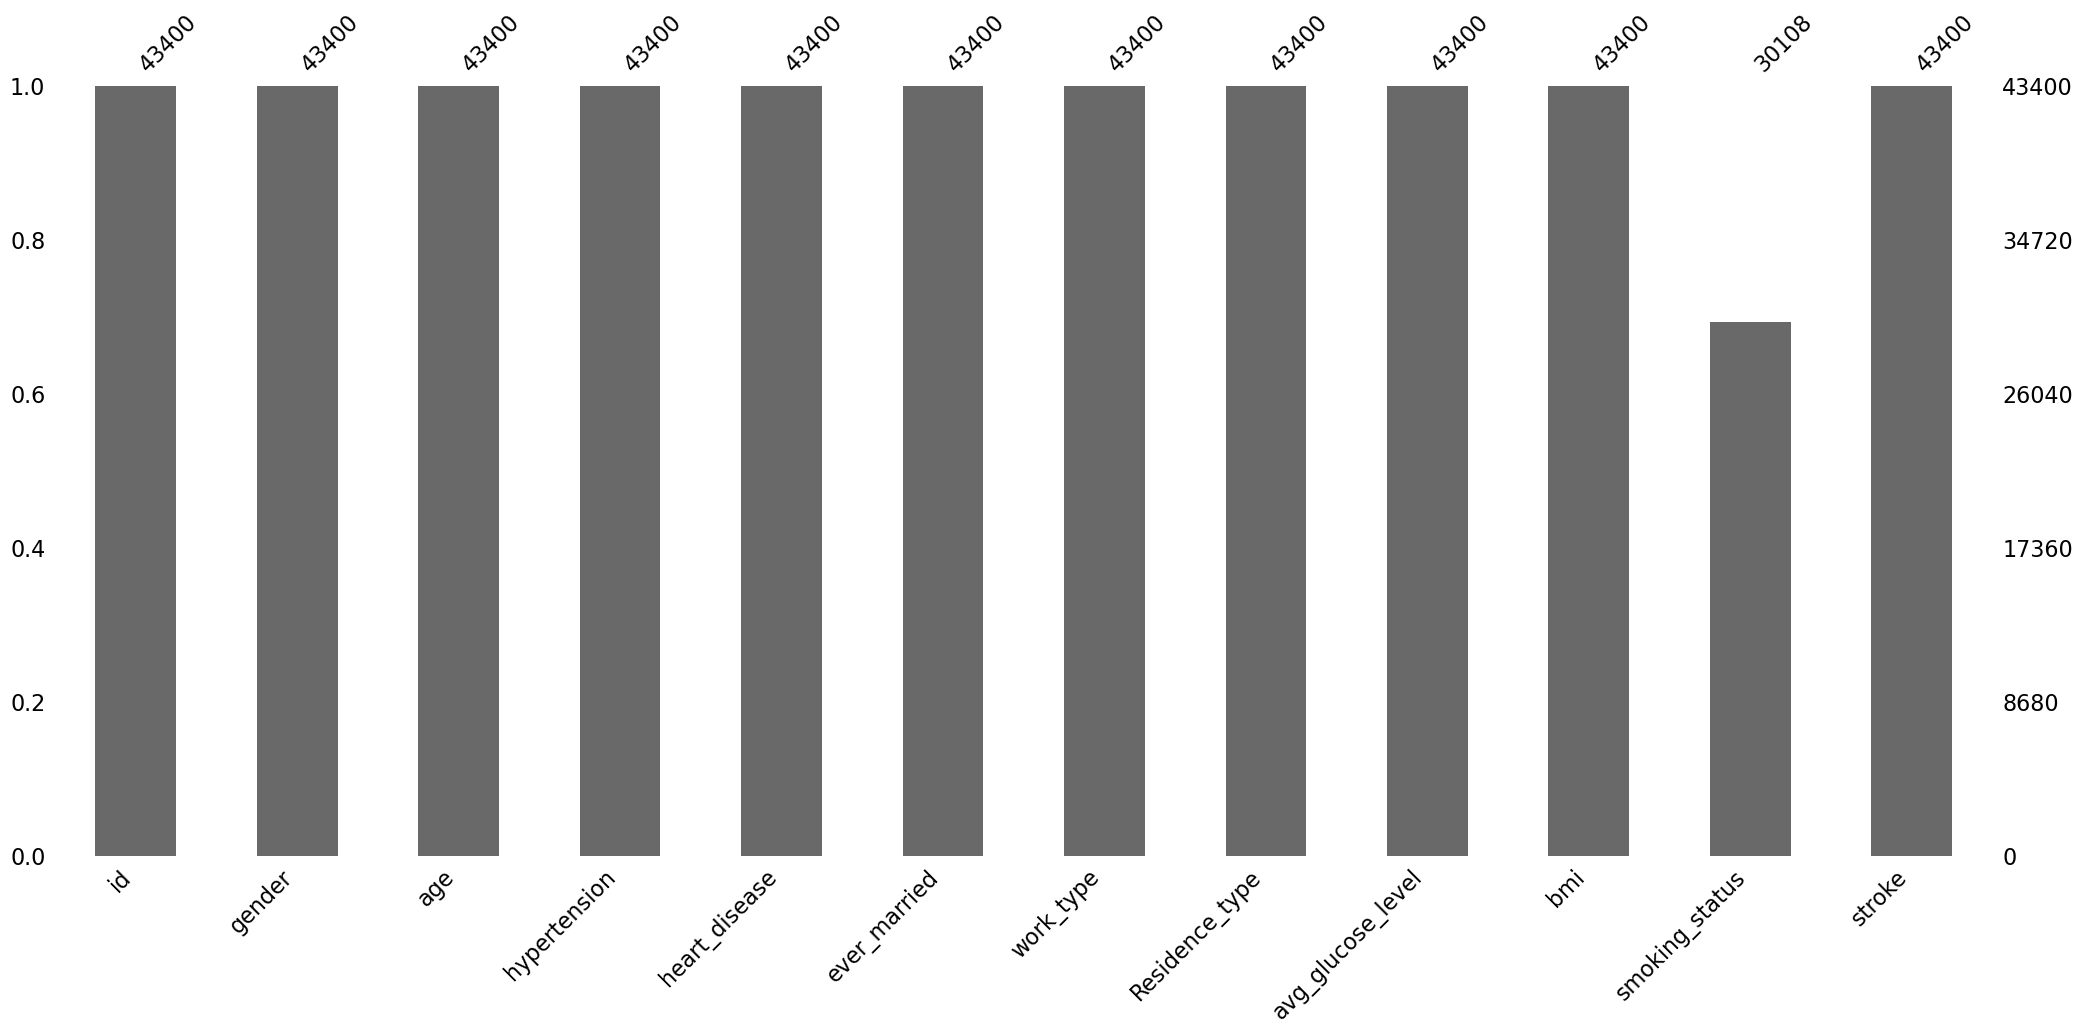

In [32]:
colonnes_manquantes = df_numerique.columns[df_numerique.isna().any()].tolist()

# Créer une copie du DataFrame pour éviter de modifier l'original
df_modifie= df.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Appliquer Label Encoding aux colonnes catégorielles dans le DataFrame modifié
for colonne in colonnes_numeriques:
    df_modifie[colonne] = label_encoder.fit_transform(df_modifie[colonne])

# Remplacement des valeurs manquantes par des prédictions dans les colonnes catégorielles
for colonne in colonnes_manquantes:
    if pd.api.types.is_numeric_dtype(df_modifie[colonne]):
        indices_colonne_manquante = df_modifie[df_modifie[colonne].isna()].index
        if any(idx in indices_lignes_manquantes for idx in indices_colonne_manquante):
            # Prédictions pour les valeurs manquantes
            y_pred_1 = rf_reg.predict(df_modifie.loc[indices_colonne_manquante, df_numerique.columns])
            # Remplacement des valeurs manquantes par les prédictions dans le DataFrame modifié
            df_modifie.loc[indices_colonne_manquante, colonne] = y_pred_1

# Affichage des graphiques manquants
msno.bar(df_modifie)


In [80]:
from sklearn.metrics import r2_score

# Initialiser et entraîner le modèle KNeighborsRegressor
rfc = RandomForestClassifier()
rfc.fit(X_train1, y_train1)
# Prédiction sur l'ensemble de test
y_pred3 = rfc.predict(X_test1)
# Calcul du score du modèle
r2_rfc = r2_score(y_test1, y_pred3)
print(f"R² Score for RandomForestClassifier: {r2_rfc}")

# Création et entraînement du modèle
dfc = DecisionTreeClassifier()
dfc.fit(X_train1, y_train1)

# Prédiction sur l'ensemble de test
y_pred4 = dfc.predict(X_test1)
# Calcul du score R²
r2_dfc = r2_score(y_test1, y_pred4)
print(f"R² Score for DecisionTreeClassifier: {r2_dfc}")

lr = LogisticRegression()
lr.fit(X_train1, y_train1)

# Prédiction sur l'ensemble de test
y_pred5 = lr.predict(X_test1)

# Calcul du score du modèle
r2_lr = r2_score(y_test1, y_pred5)
print(f"R² Score for LogisticRegression: {r2_lr}") 

# Comparaison des scores et utilisation du modèle avec le score le plus élevé
if r2_rfc > r2_dfc and r2_rfc > r2_lr:
    selected_model1 = rfc
    print("RandomForestClassifier selected.")
elif r2_dfc > r2_rfc and r2_dfc > r2_lr:
    selected_model1 = rf_dfc
    print("DecisionTreeClassifier selected.")
else:
    selected_model1 = lr
    print("LogisticRegression selected.")



R² Score for RandomForestClassifier: -0.03896714430453074
R² Score for DecisionTreeClassifier: -0.03896714430453074
R² Score for LogisticRegression: -0.025021276595745157
LogisticRegression selected.


<Axes: >

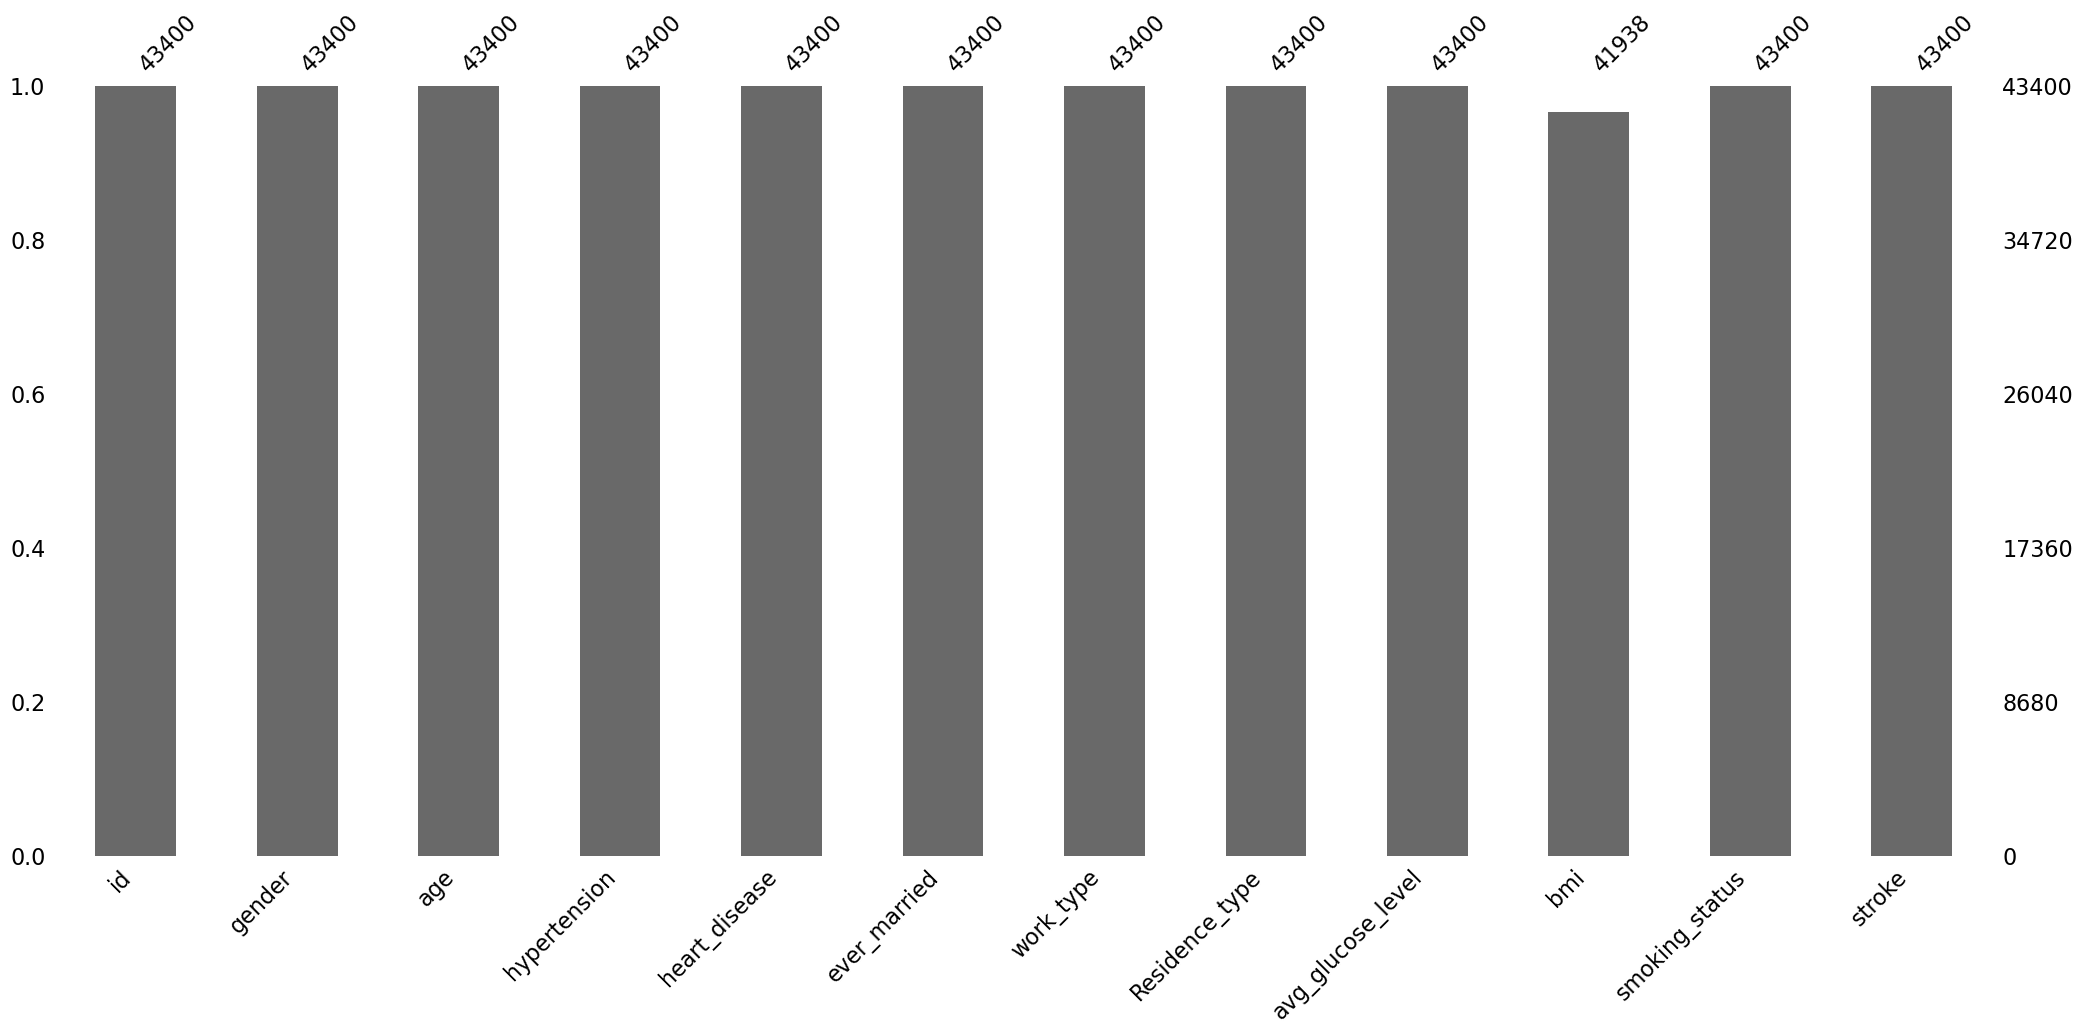

In [33]:
colonnes_manquantes1 = df_categoriel.columns[df_categoriel.isna().any()].tolist()

# Créer une copie du DataFrame pour éviter de modifier l'original
df_modifie_categoriel = df.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Appliquer Label Encoding aux colonnes catégorielles dans le DataFrame modifié
for colonne in colonnes_categorielles:
    df_modifie_categoriel[colonne] = label_encoder.fit_transform(df_modifie_categoriel[colonne])

# Remplacement des valeurs manquantes par des prédictions dans les colonnes catégorielles
for colonne in colonnes_manquantes1:
    if pd.api.types.is_categorical_dtype(df_modifie_categoriel[colonne]):
        indices_colonne_manquante = df_modifie_categoriel[df_modifie_categoriel[colonne].isna()].index
        if any(idx in indices_lignes_manquantes for idx in indices_colonne_manquante):
            # Prédictions pour les valeurs manquantes
            y_pred_1 = selected_model1.predict(df_modifie_categoriel.loc[indices_colonne_manquante, df_categoriel.columns])
            # Remplacement des valeurs manquantes par les prédictions dans le DataFrame modifié
            df_modifie_categoriel.loc[indices_colonne_manquante, colonne] = y_pred_1

# Affichage des graphiques manquants
msno.bar(df_modifie_categoriel)
